In [ ]:
!pip install --quiet gspread gspread_dataframe oauth2client

In [ ]:
!pip install -q PyDrive

In [ ]:
!pip install -q rembg onnxruntime faiss-cpu opencv-python-headless scikit-learn colormath tqdm pillow

In [ ]:
#@title Subida Clave
from google.colab import files
files.upload()  # ← sube aquí tu archivo JSON

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

BASE_MODELS = '/content/drive/MyDrive/IABD/models2'
BASE_COLOR = '/content/drive/MyDrive/IABD/Recomendacion/features'
IMG_BASE_PATH = '/content/drive/MyDrive/IABD/archive'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title Conexión a Google Sheets
import gspread
from oauth2client.service_account import ServiceAccountCredentials

def conectar_sheet(sheet_name="Resultados"):
    scope = ["https://spreadsheets.google.com/feeds", "https://www.googleapis.com/auth/drive"]
    creds = ServiceAccountCredentials.from_json_keyfile_name("service_account.json", scope)
    client = gspread.authorize(creds)
    sheet = client.open(sheet_name).worksheet("Resultados")
    return sheet


In [ ]:
# 📦 Autenticación con Drive para PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# ID de la carpeta pública en tu Google Drive (¡Cámbialo por el tuyo!)
DRIVE_FOLDER_ID = '1y4MXD88_203vg0NWqE9Xrj1fy96CUoG5'

# 📤 Subir imagen local a la carpeta pública de Drive
def subir_a_drive_publico(local_path, remote_name, folder_id):
    file_drive = drive.CreateFile({
        'title': remote_name,
        'parents': [{'id': folder_id}]
    })
    file_drive.SetContentFile(local_path)
    file_drive.Upload()
    return f"https://drive.google.com/uc?export=view&id={file_drive['id']}"


In [ ]:
#@title Cargar modelos, índices y recursos
import faiss, cv2, pandas as pd, joblib, os, gc, tensorflow as tf
from colormath.color_objects import LabColor
from colormath.color_diff import delta_e_cie2000

import numpy as np
print(np.__version__)

if not hasattr(np, 'asscalar'):
    np.asscalar = lambda array: array.item()

# Clasificador y encoder
model_clf = tf.keras.models.load_model(f'{BASE_MODELS}/model_final.keras', compile=False)
label_enc = joblib.load(f'{BASE_MODELS}/label_encoder.pkl')

# Backbone visual (embedding)
backbone = tf.keras.applications.EfficientNetV2S(include_top=False, pooling='avg', weights=None)
backbone.load_weights(f'{BASE_MODELS}/EfficientNetV2S_224.weights.h5')

# FAISS: estilo visual
embed_index = faiss.read_index(f'{BASE_MODELS}/faiss_index.bin')
image_paths = np.load(f'{BASE_MODELS}/image_paths.npy', allow_pickle=True)

# FAISS: color
color_df = pd.read_parquet(f'{BASE_COLOR}/catalog_lab.parquet').reset_index(drop=True)
color_index = faiss.read_index(f'{BASE_COLOR}/faiss_lab.idx')


2.0.2


In [ ]:
#@title Funciones auxiliares
from rembg import remove
from sklearn.cluster import KMeans
from IPython.display import display, Image
from matplotlib import pyplot as plt

def preprocess(img_bgr):
    img = cv2.resize(img_bgr, (224,224))
    img = img[..., ::-1] / 255.0  # BGR → RGB
    return np.expand_dims(img, 0).astype('float32')

def get_embedding(img_bgr):
    return backbone(preprocess(img_bgr)).numpy().astype('float32')

def dominant_lab(img_bgr, k=3):
    """
    Extrae el color dominante eliminando el fondo con rembg.
    """
    try:
        mask = remove(img_bgr, only_mask=True)
    except Exception as e:
        print("⚠️ Error al eliminar fondo con rembg:", e)
        mask = np.ones(img_bgr.shape[:2], dtype=np.uint8) * 255

    lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)
    lab_prenda = lab[mask > 0]
    km = KMeans(n_clusters=k, n_init=10).fit(lab_prenda.reshape(-1, 3))
    dominante = km.cluster_centers_[np.bincount(km.labels_).argmax()]
    return dominante.astype(np.float32)

def lab_to_rgb(lab):
    lab = np.clip(lab, 0, 255).astype('uint8').reshape(1,1,3)
    rgb = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)[0,0,::-1]
    return tuple(int(c) for c in rgb)


In [ ]:
#@title Funciones de recomendación
def recommend_by_color(img_bgr, top_k=6):
    lab_q = dominant_lab(img_bgr, k=3)
    D, I = color_index.search(lab_q.reshape(1,3).astype('float32'), top_k)
    results = color_df.iloc[I[0]].copy()
    results['score'] = 1 - D[0] / 100
    return lab_q, results[['score', 'path']]

def recommend_by_visual(img_bgr, top_k=6):
    emb = get_embedding(img_bgr)
    D, I = embed_index.search(emb, top_k)
    return pd.DataFrame({
        'score': 1 - D[0] / D[0].max(),
        'path': [image_paths[i] for i in I[0]]
    })

def recommend_hybrid(img_bgr, alpha=0.75, top_k=6):
    emb = get_embedding(img_bgr)
    Dv, Iv = embed_index.search(emb, 100)

    lab_q = dominant_lab(img_bgr, k=3)

    rows = []
    for dist, idx in zip(Dv[0], Iv[0]):
        lab_cand = color_df.iloc[idx][['L','a','b']].values
        sim_col = 1 - delta_e_cie2000(LabColor(*lab_q), LabColor(*lab_cand)) / 100
        sim_vis = 1 - dist / Dv[0].max()
        score = alpha * sim_vis + (1 - alpha) * sim_col
        rows.append({'score': score, 'path': image_paths[idx]})

    return lab_q, pd.DataFrame(rows).sort_values('score', ascending=False).head(top_k)


In [ ]:
def demo_completa(img_path, alpha=0.75, top_k=6):
    # 1. Cargar imagen
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # 2. Mostrar imagen de entrada
    plt.figure(figsize=(3,3))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title("📷 Imagen de entrada")
    plt.show()

    # 3. Clasificación de prenda
    pred = model_clf.predict(preprocess(img_bgr))
    pred_class = label_enc.inverse_transform([np.argmax(pred)])[0]
    print(f"🧵 Prenda estimada: **{pred_class}**")

    # 4. Color dominante
    lab = dominant_lab(img_bgr)
    rgb = lab_to_rgb(lab)
    print(f"🎨 Color dominante (L,a,b): {np.round(lab, 2)}")

    plt.figure(figsize=(1,1)); plt.axis('off')
    plt.imshow([[(rgb[0]/255, rgb[1]/255, rgb[2]/255)]])
    plt.title("Color dominante")
    plt.show()

    # 5. Mostrar las 3 recomendaciones
    lab, rec_color = recommend_by_color(img_bgr, top_k=top_k)
    rec_visual = recommend_by_visual(img_bgr, top_k=top_k)
    _, rec_hybrid = recommend_hybrid(img_bgr, alpha=alpha, top_k=top_k)

    show_results_grid(rec_color, "🔴 Recomendación por Color")
    show_results_grid(rec_visual, "⚫ Recomendación por Estilo Visual")
    show_results_grid(rec_hybrid, f"🟣 Recomendación Híbrida (α={alpha})")

    # 6. devuelve valores para guardar en sheets
    return pred_class, lab, rec_color, rec_visual, rec_hybrid



In [ ]:
from PIL import Image as PILImage

def guardar_color_como_imagen(rgb, out_path="color_predominante.jpg"):
    img = PILImage.new("RGB", (50, 50), rgb)
    img.save(out_path)
    return out_path


In [ ]:
import shutil
import os
import pandas as pd
from gspread_dataframe import get_as_dataframe, set_with_dataframe

def guardar_resultado_en_sheet(sheet, img_path, pred_class, lab, rec_color, rec_visual, rec_hybrid):
    # 1. Copiar imagen de entrada
    local_input_copy = f"entrada_{os.path.basename(img_path)}"
    shutil.copy(img_path, local_input_copy)
    url_entrada = subir_a_drive_publico(local_input_copy, local_input_copy, DRIVE_FOLDER_ID)

    # 2. Guardar imagen del color dominante
    rgb_color = lab_to_rgb(lab)
    color_img_path = guardar_color_como_imagen(rgb_color, "color_pred.jpg")
    url_color = subir_a_drive_publico(color_img_path, f"color_{os.path.basename(img_path)}", DRIVE_FOLDER_ID)

    # 3. Crear fila de datos
    fila = {
        "img_entrada_url": url_entrada,
        "clase_predicha": pred_class,
        "L": round(lab[0], 2),
        "a": round(lab[1], 2),
        "b": round(lab[2], 2),
        "color_img_url": url_color
    }

    # 4. Subir recomendaciones y guardar URLs
    for i in range(6):
        for tipo, df in zip(["color", "visual", "hybrid"], [rec_color, rec_visual, rec_hybrid]):
            if i < len(df):
                local_name = f"{tipo}_{i+1}_{os.path.basename(df['path'].iloc[i])}"
                shutil.copy(df['path'].iloc[i], local_name)
                url = subir_a_drive_publico(local_name, local_name, DRIVE_FOLDER_ID)
                fila[f"rec_{tipo}_{i+1}"] = url
            else:
                fila[f"rec_{tipo}_{i+1}"] = ""

    # 5. Guardar en Google Sheet
    df_existente = get_as_dataframe(sheet, evaluate_formulas=True).dropna(how='all')
    df_nuevo = pd.concat([df_existente, pd.DataFrame([fila])], ignore_index=True)
    set_with_dataframe(sheet, df_nuevo)




In [ ]:
#@title Demo de comparador visual
# TEST_IMG = '/content/drive/MyDrive/IABD/archive/Demo/29704785947c070fdb71c44deb6579ce.jpg'
# img_bgr = cv2.imread(TEST_IMG)

# lab, rec_color = recommend_by_color(img_bgr)
# rec_visual = recommend_by_visual(img_bgr)
# _, rec_hybrid = recommend_hybrid(img_bgr, alpha=0.75)

# print("Color dominante (L,a,b):", lab)
# plt.figure(figsize=(1,1)); plt.axis('off')
# rgb = lab_to_rgb(lab); plt.imshow([[(c/255) for c in rgb]])
# plt.show()

def show_results(df, title):
    print(f'🔸 {title}')
    for p in df['path']:
        display(Image(p, width=140))

def show_results_grid(df, title="Recomendaciones", ncols=3, img_width=150):
    from matplotlib import pyplot as plt
    from PIL import Image as PILImage

    st_paths = df['path'].tolist()
    n_images = len(st_paths)
    nrows = (n_images + ncols - 1) // ncols

    plt.figure(figsize=(ncols*2.5, nrows*3))
    for i, path in enumerate(st_paths):
        plt.subplot(nrows, ncols, i+1)
        try:
            img = PILImage.open(path)
            plt.imshow(img)
            plt.axis('off')
        except:
            plt.text(0.5, 0.5, "⚠️ Error", ha='center', va='center')
            plt.axis('off')
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()


# show_results_grid(rec_color, "🔴 Recomendación por Color")
# show_results_grid(rec_visual, "⚫ Recomendación por Estilo Visual")
# show_results_grid(rec_hybrid, "🟣 Recomendación Híbrida (α=0.75)")



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128247 (\N{CAMERA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


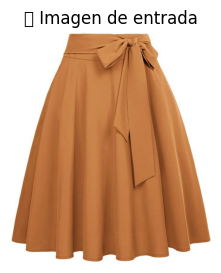

1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
🧵 Prenda estimada: **Skirt**
🎨 Color dominante (L,a,b): [148.78 150.73 167.92]


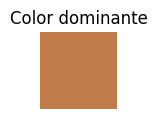

<ipython-input-15-e8b972ae7f3b>:38: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


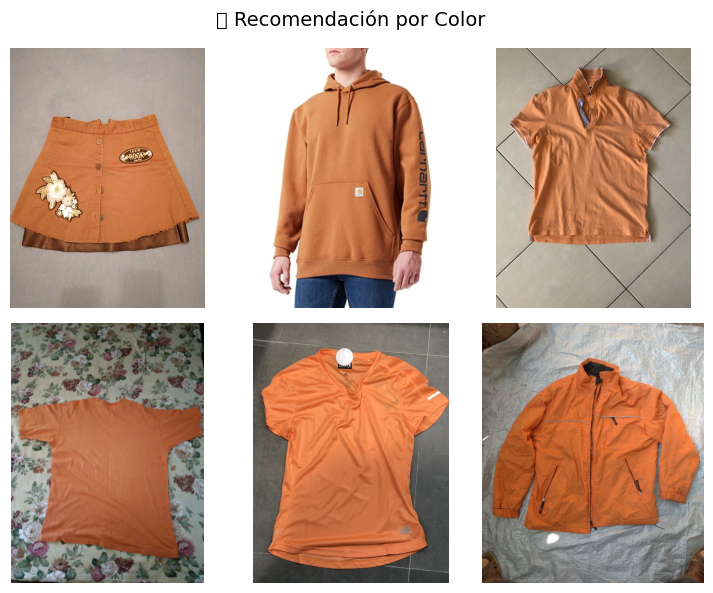

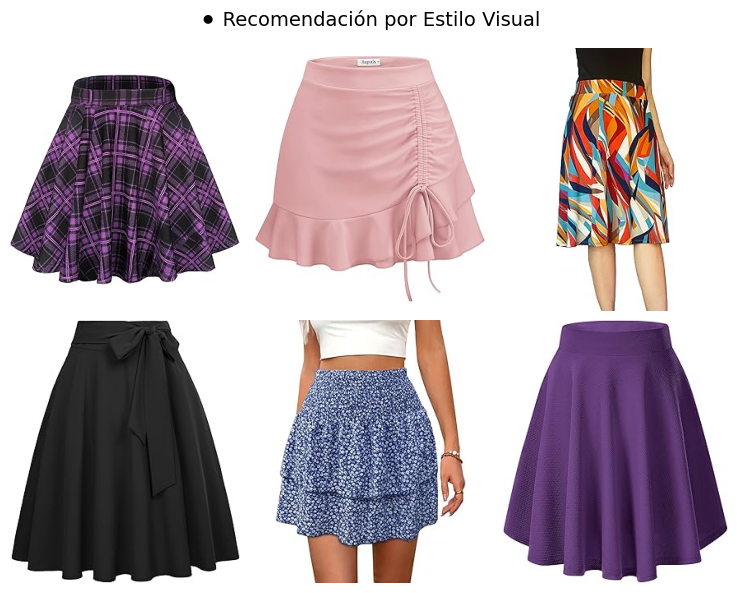

<ipython-input-15-e8b972ae7f3b>:38: UserWarning: Glyph 128995 (\N{LARGE PURPLE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128995 (\N{LARGE PURPLE CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


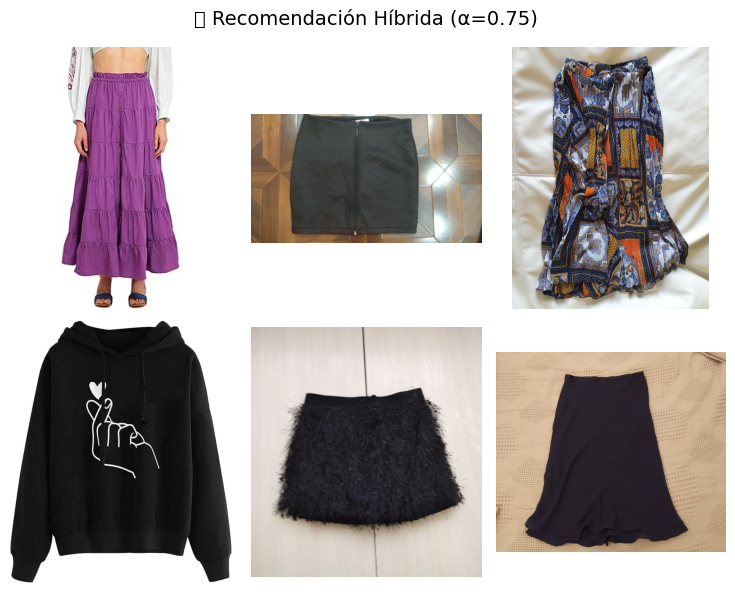

<ipython-input-14-54d1efc8d0df>:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_nuevo = pd.concat([df_existente, pd.DataFrame([fila])], ignore_index=True)


In [ ]:
img_path = "/content/drive/MyDrive/IABD/archive/Demo/5fd5acb54a3fd92d9c06ba8135e82882.jpg"
pred_class, lab, rec_color, rec_visual, rec_hybrid = demo_completa(img_path)

sheet = conectar_sheet()
guardar_resultado_en_sheet(sheet, img_path, pred_class, lab, rec_color, rec_visual, rec_hybrid)